In [151]:
import tensorflow as tf # Imports tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, LSTM,Bidirectional,Attention,Concatenate
from tensorflow.keras import regularizers, optimizers,losses
from tensorflow.keras.metrics import Recall,Precision,AUC,TruePositives,TrueNegatives,FalseNegatives,FalsePositives, SpecificityAtSensitivity,SensitivityAtSpecificity
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils import np_utils
import numpy as np
import pandas as pd 
import matplotlib
import seaborn as sns
import sklearn

from imblearn.over_sampling import RandomOverSampler 
import imblearn
#from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
import os
import sklearn.metrics as m
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import skimage.io
import skimage.color
import skimage.filters


In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image

In [108]:
np.random.seed(42)
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
# import autokeras as ak

## Visualize the Dataset

In [109]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [91]:
skin_df.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
def prepare_dataframe():
    image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('data/', '*', '*.jpg'))}
    skin_df['path'] = skin_df['image_id'].map(image_path.get)
    skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x)))
prepare_dataframe()

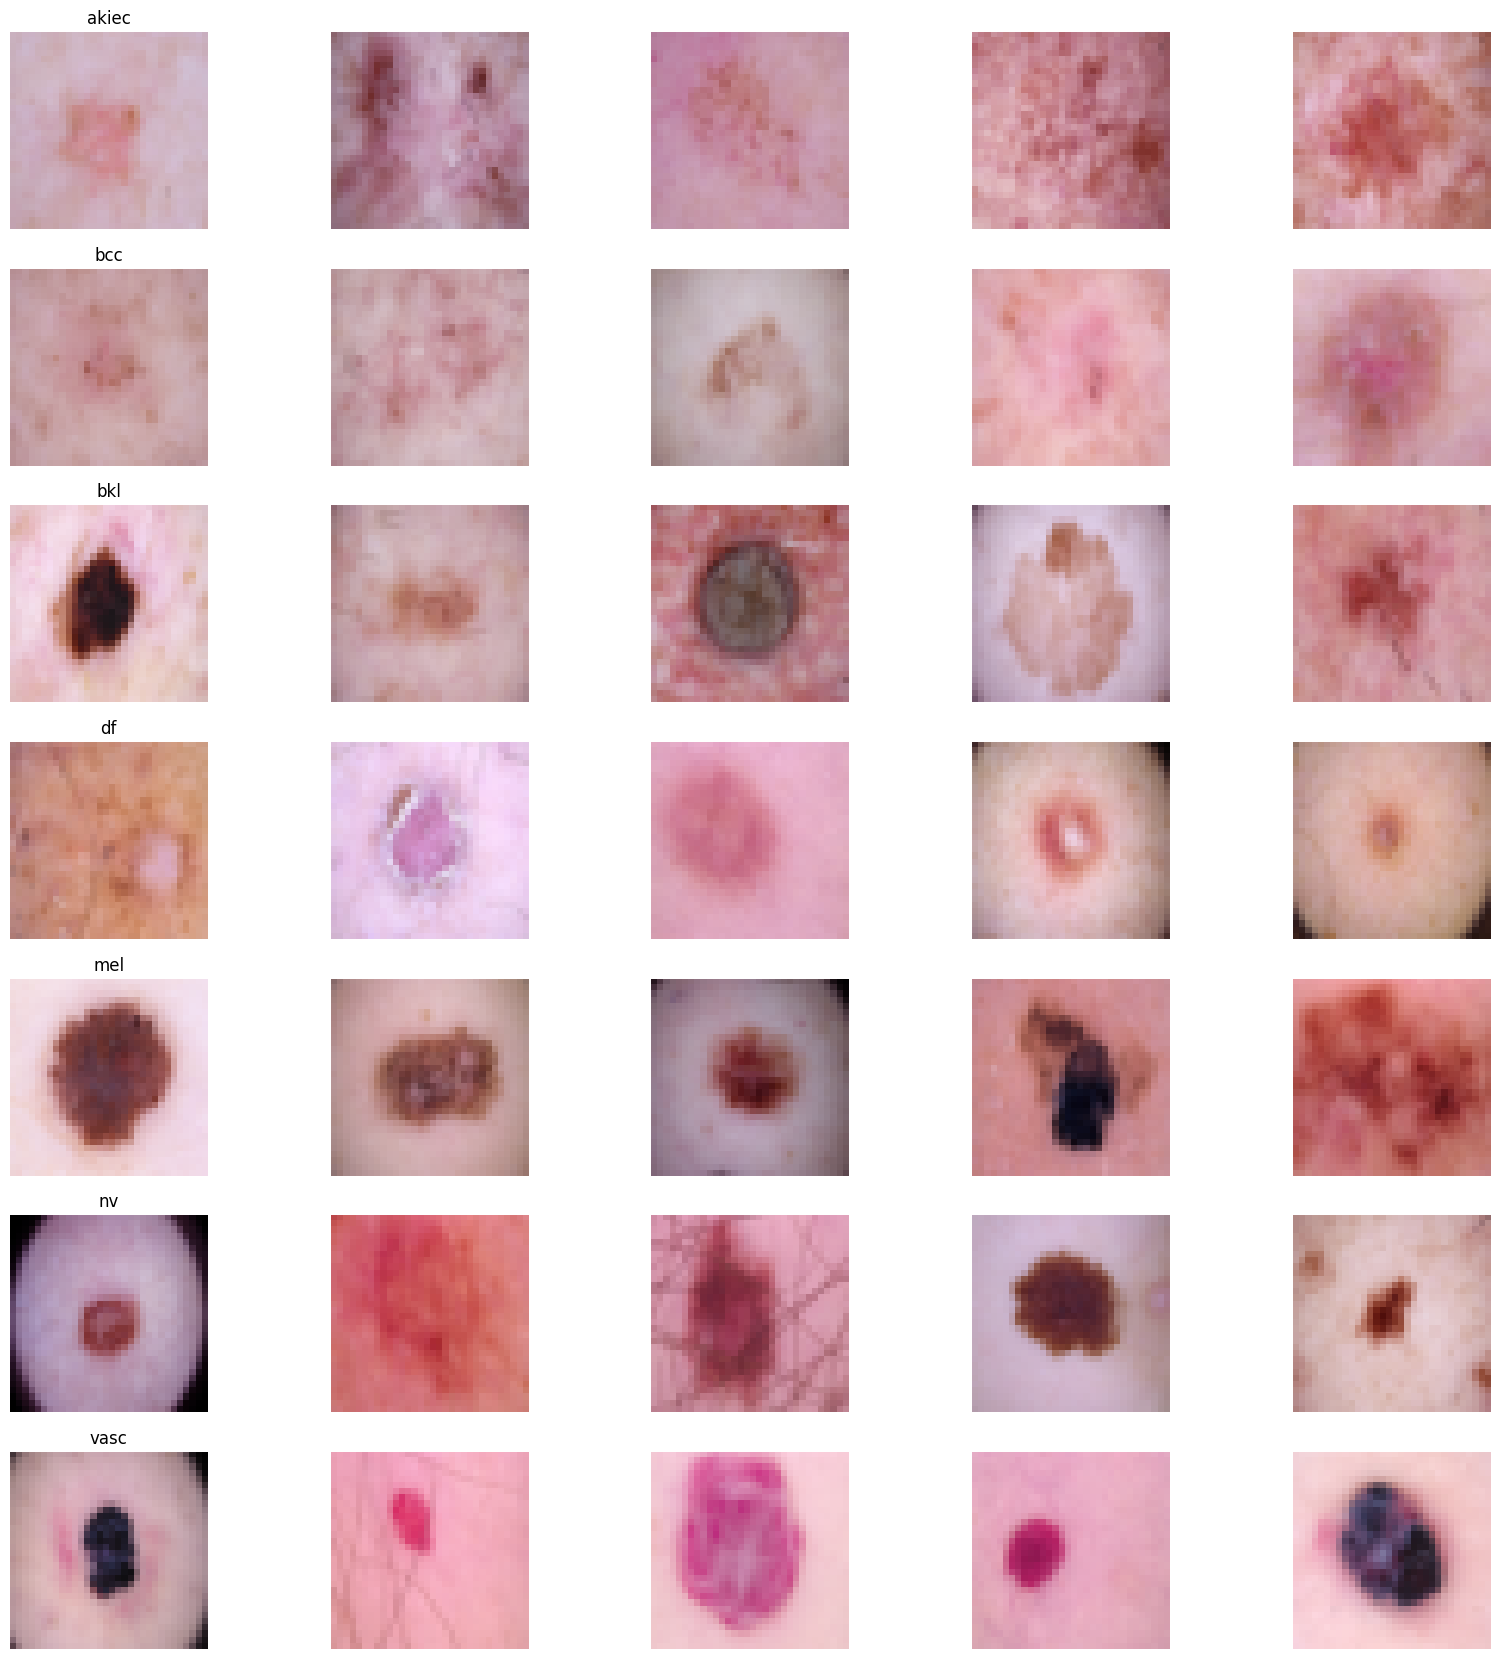

In [27]:
def visualization(n_samples=5):
    fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
    for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['dx']).groupby('dx')):
        n_axs[0].set_title(type_name)
        for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
            c_ax.imshow(c_row['image'])
            c_ax.axis('off')
            
visualization()

## Analyze the Dataset

C:\Users\MTT\AppData\Local\Temp\ipykernel_16420\2478423784.py:22: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




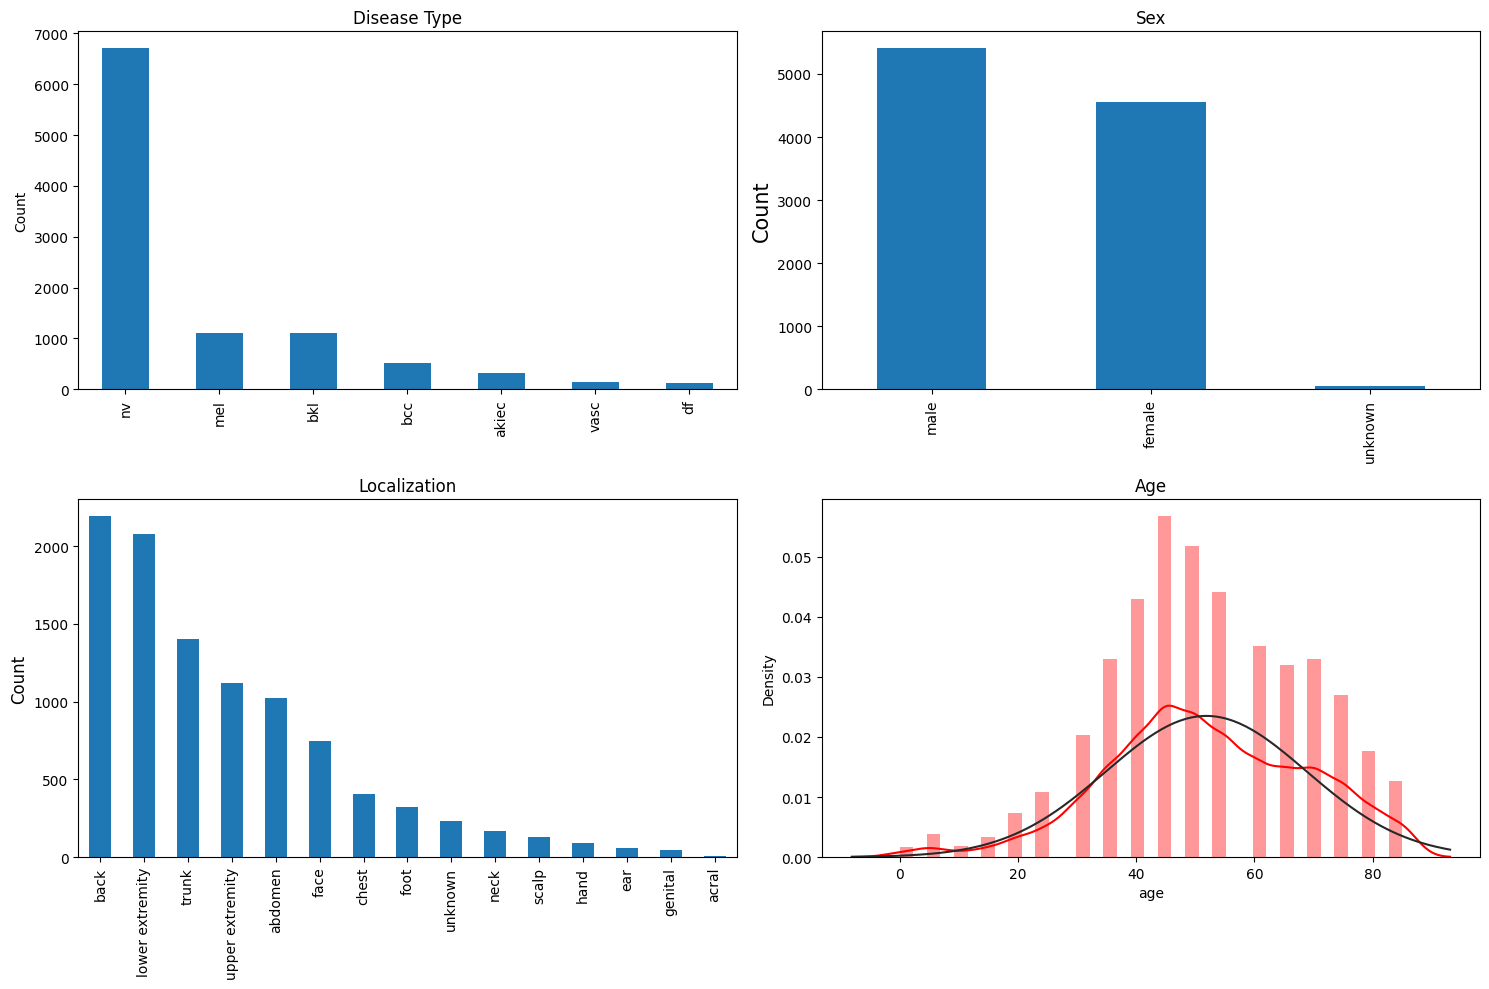

In [45]:
def visualize_data_distribution():
    fig = plt.figure(figsize=(15,10))

    ax1 = fig.add_subplot(221)
    skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
    ax1.set_ylabel('Count')
    ax1.set_title('Disease Type');

    ax2 = fig.add_subplot(222)
    skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
    ax2.set_ylabel('Count', size=15)
    ax2.set_title('Sex');

    ax3 = fig.add_subplot(223)
    skin_df['localization'].value_counts().plot(kind='bar')
    ax3.set_ylabel('Count',size=12)
    ax3.set_title('Localization')


    ax4 = fig.add_subplot(224)
    sample_age = skin_df[pd.notnull(skin_df['age'])]
    sns.distplot(sample_age['age'], fit=stats.norm, color='red');
    ax4.set_title('Age')

    plt.tight_layout()
    plt.show()
    
visualize_data_distribution()

In [46]:
import plotly.express as px
px.histogram(skin_df.dx, color=skin_df.dx, title='Diseases Type')

In [47]:
px.histogram(skin_df.localization, color=skin_df.localization, title='Localization')

In [53]:
px.histogram(skin_df.sex, color=skin_df.sex, title='Sex')

In [52]:
def map_age(row):
    if row.age < 30:
        return 'Young'
    elif row.age >= 30 and row.age < 60:
        return 'middle-aged'
    else:
        return 'old'
    
skin_df['age_distribution'] = skin_df.apply(map_age, axis=1)
px.histogram(skin_df.age_distribution, color=skin_df.age_distribution, title='Sex')

## Split into category folders for managment

In [28]:
import pandas as pd
import os
import shutil

In [36]:
if not os.path.exists("data/train"):
    os.makedirs("data/main_data")

for subfolder in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
    subfolder_path = os.path.join("data", subfolder)
    for file in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, file)
        if file_path.endswith(".jpg") or file_path.endswith(".png"):
            shutil.copy(file_path, "data/main_data")

In [ ]:
def create_subfolder_classes():
    data_dir = os.getcwd() + "/data/main_data/"
    dest_dir = os.getcwd() + "/data/reorganized/"
    label = skin_df['dx'].unique().tolist()  #Extract labels into a list
    label_images = []
    
    for i in label:
        os.mkdir(dest_dir + str(i) + "/")
        sample = skin_df[skin_df.dx == i].image_id
        label_images.extend(sample)
        for id in label_images:
            shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+ id + ".jpg"))
        label_images=[]    
        
create_subfolder_classes()

## Balance the dataset

In [130]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [131]:
def map_label_column(row):
    if row.dx == 'nv':
        return 0
    elif row.dx == 'mel':
        return 1
    elif row.dx == 'bkl':
        return 2
    elif row.dx == 'bcc':
        return 3
    elif row.dx == 'akiec':
        return 4
    elif row.dx == 'vasc':
        return 5
    elif row.dx == 'df':
        return 6
    
skin_df['label'] = skin_df.apply(map_label_column, axis=1)
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
3697,HAM_0005218,ISIC_0028939,nv,follow_up,55.0,female,lower extremity,0
7213,HAM_0007444,ISIC_0033989,nv,histo,50.0,female,lower extremity,0
310,HAM_0002839,ISIC_0032280,bkl,histo,60.0,female,lower extremity,2
4438,HAM_0005070,ISIC_0030863,nv,follow_up,55.0,female,trunk,0
6087,HAM_0005969,ISIC_0028257,nv,follow_up,35.0,male,abdomen,0
3586,HAM_0001464,ISIC_0028319,nv,follow_up,70.0,male,trunk,0
3733,HAM_0003513,ISIC_0030743,nv,follow_up,60.0,male,upper extremity,0
718,HAM_0001359,ISIC_0028628,bkl,histo,75.0,male,lower extremity,2
2090,HAM_0006006,ISIC_0028847,mel,histo,75.0,male,chest,1
3417,HAM_0002741,ISIC_0027939,nv,follow_up,45.0,female,abdomen,0


In [133]:
from sklearn.utils import resample
n_samples = 500
skin_df_balanced = pd.DataFrame()
for label in range(7):
    df_label = skin_df[skin_df['label'] == label]
    df_label_balanced = resample(df_label, replace=True, n_samples=n_samples, random_state=42)
    skin_df_balanced = pd.concat([skin_df_balanced, df_label_balanced])

In [135]:
skin_df_balanced.label.value_counts()

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64

In [144]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('data/reorganized/', '*', '*.jpg'))}
skin_df_balanced['path'] = skin_df_balanced['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [149]:
y = np.array(skin_df['label'])
y = to_categorical(y) # one-hot encoding
x = np.array(skin_df['image'])
x = np.stack(x) 
x = x.reshape(x.shape, 28, 28, 3) 

In [170]:
data = pd.read_csv('data\hmnist_28_28_RGB.csv')
y = data['label']
x = data.drop(columns = ['label'])
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)
x= np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)
y = to_categorical(y)

Shape of X : (46935, 28, 28, 3)


In [172]:
x = (x-np.mean(x)) / np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

## Train the model

In [173]:
def blockred(inp, filters):
    # Inception
    x = Conv2D(filters, 1, activation="relu", padding='same',use_bias=False)(inp)
    x = layers.MaxPooling2D(2)(x)
    x = BatchNormalization(axis=1)(x)
    
    # VGG + SQuizenet
    y = Conv2D(filters*2,3,activation="relu", padding='same',use_bias=False,)(inp)
    y = Conv2D(filters,3,activation="relu", padding='same',use_bias=False,)(y)
    y = layers.MaxPooling2D(2)(y)
    y = BatchNormalization(axis=1)(y)
    y = Dropout(0.25)(y)
    
    # InceptionResnet + Squize
    z = Conv2D(filters*2, 3, activation="relu", padding='same',use_bias=False)(inp)
    z = Conv2D(filters, 1, activation="relu", padding='same',use_bias=False)(inp)  
    z = layers.MaxPooling2D(2)(z)
    z = BatchNormalization(axis=1)(z)
    output1 = layers.add([x,y,z])
    return output1

In [174]:
Name= "CNN0"
inputs = keras.Input(shape=(28,28,3), name="img")

x = layers.Conv2D(32, 3, activation="relu")(inputs)
block_1 = blockred(x,32)
block_2 = blockred(block_1,64)
block_3 = blockred(block_2,64)

y = Flatten()(block_3)
y = Dense(256, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(64, activation='relu')(y)
y = Dropout(0.5)(y)

outputs = Dense(7, activation='softmax')(y)
model = keras.Model(inputs, outputs, name=Name)
print(model.summary())

Model: "CNN0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 26, 26, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_29 (Conv2D)             (None, 26, 26, 64)   18432       ['conv2d_27[0][0]']              
                                                                                                  
 conv2d_30 (Conv2D)             (None, 26, 26, 32)   18432       ['conv2d_29[0][0]']              
                                                                                               

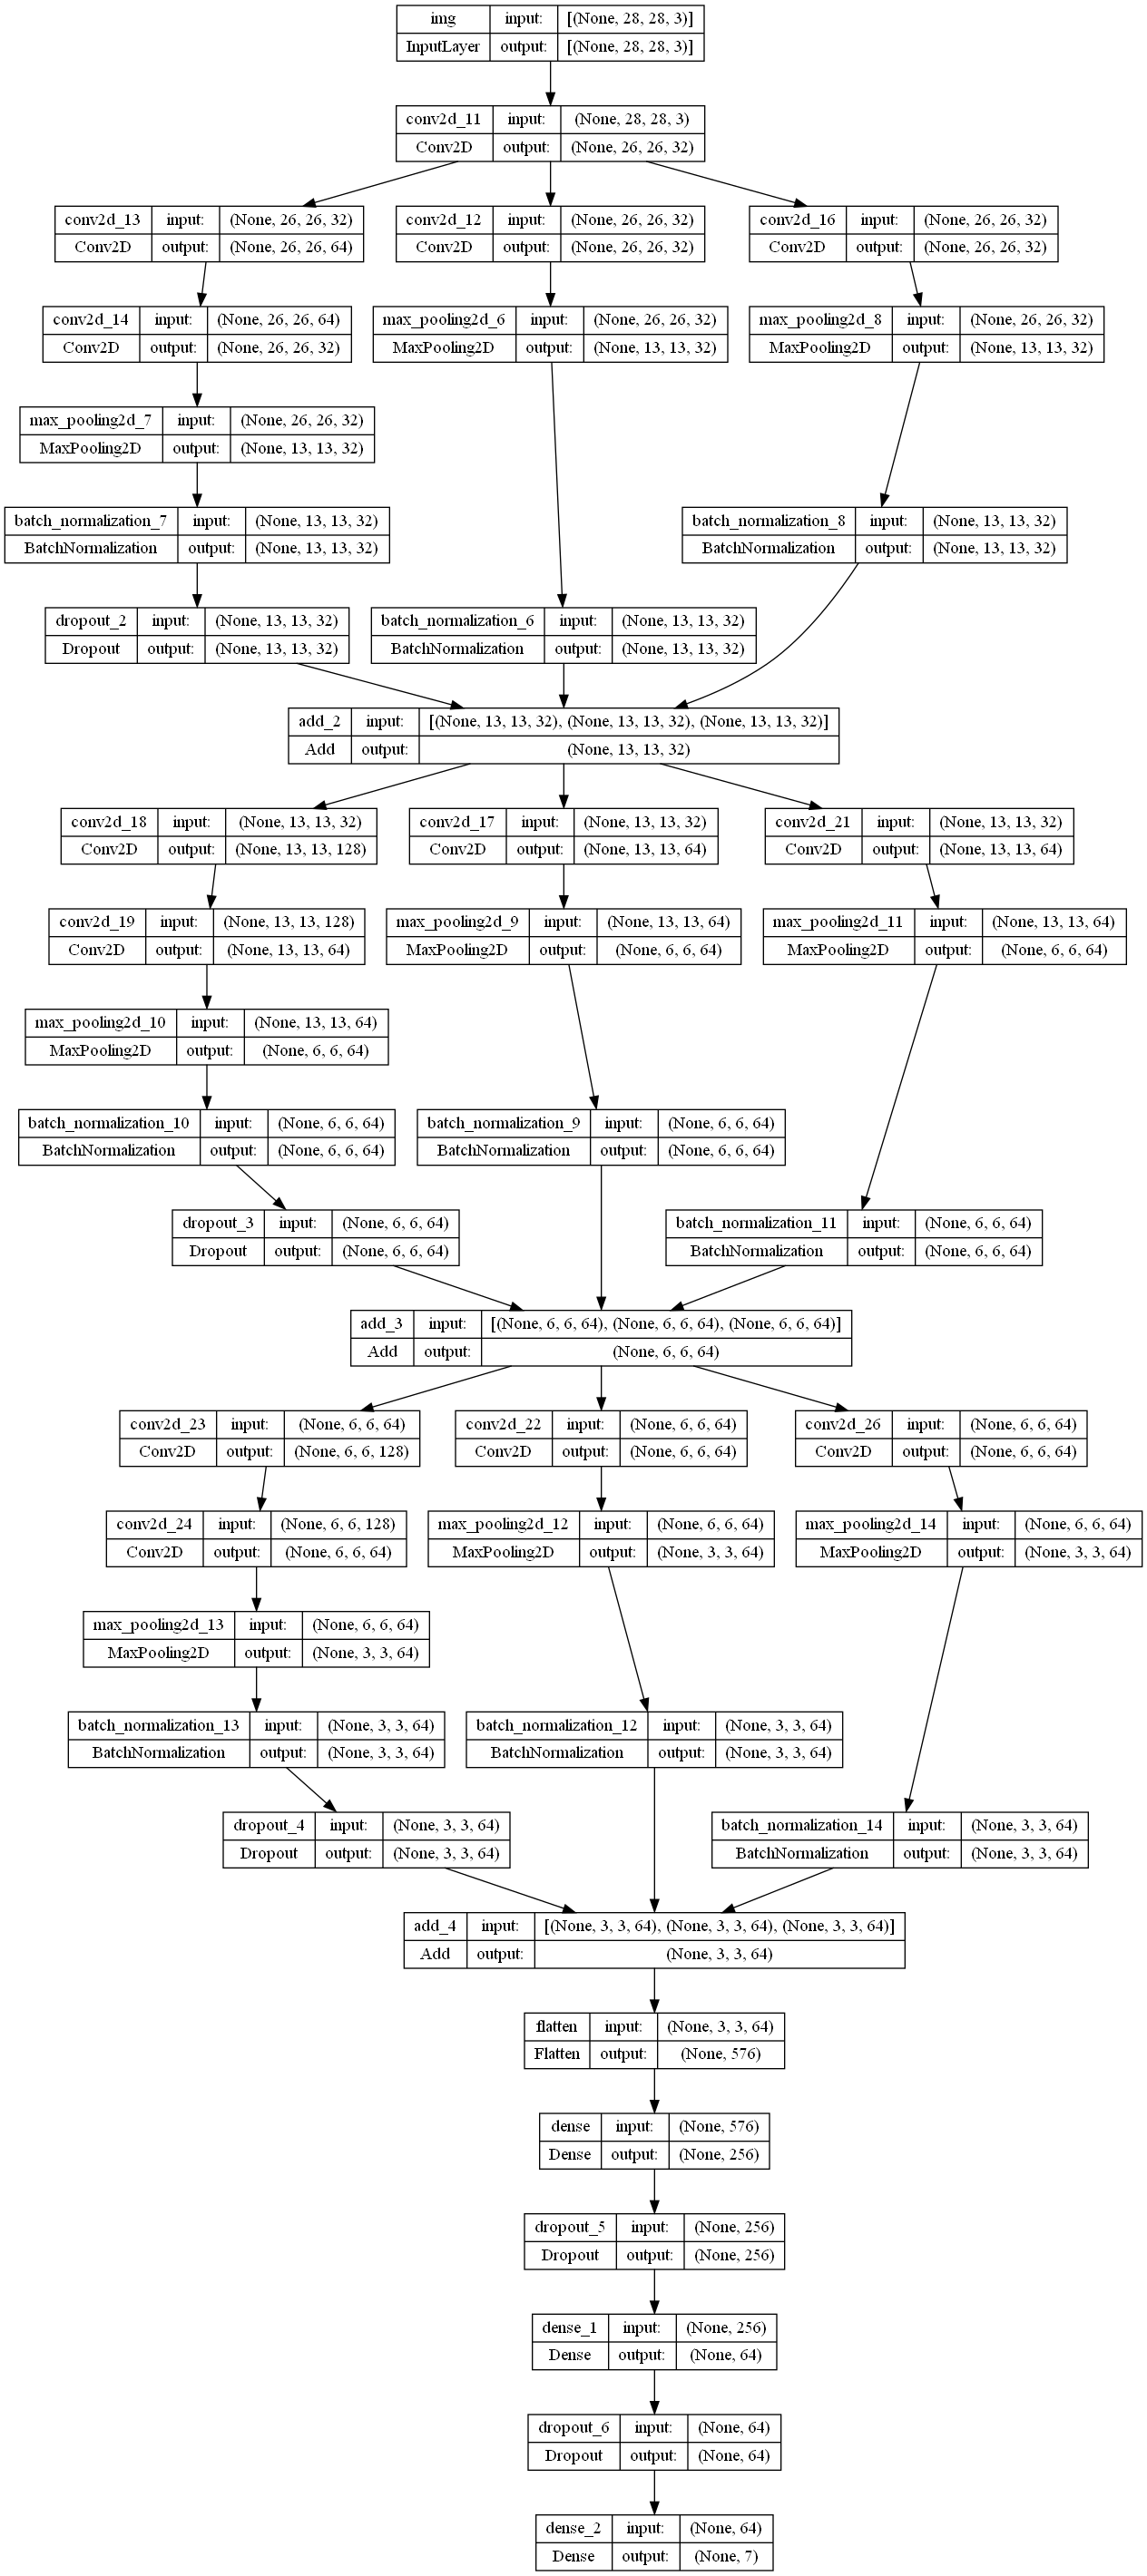

In [163]:
plot_model(model, to_file=Name+'.png', show_shapes= True , show_layer_names=True)

In [175]:
callback = tf.keras.callbacks.ModelCheckpoint( filepath='best_model.h5', monitor='val_acc', mode='max', verbose=1)

model.compile(optimizer= keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy() ,
              metrics=['acc',Recall(),Precision(),AUC(),TruePositives(),TrueNegatives(),FalseNegatives(),FalsePositives()])
history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_test, Y_test), batch_size=128, callbacks=[callback])

Epoch 1/15
294/294 [==============================] - ETA: 0s - loss: 1.7669 - acc: 0.2990 - recall_1: 0.0833 - precision_1: 0.5287 - auc_1: 0.7088 - true_positives_1: 3127.0000 - true_negatives_1: 222500.0000 - false_negatives_1: 34421.0000 - false_positives_1: 2788.0000
Epoch 1: saving model to best_model.h5
294/294 [==============================] - 579s 2s/step - loss: 1.7669 - acc: 0.2990 - recall_1: 0.0833 - precision_1: 0.5287 - auc_1: 0.7088 - true_positives_1: 3127.0000 - true_negatives_1: 222500.0000 - false_negatives_1: 34421.0000 - false_positives_1: 2788.0000 - val_loss: 1.6487 - val_acc: 0.3654 - val_recall_1: 0.0841 - val_precision_1: 0.9415 - val_auc_1: 0.7506 - val_true_positives_1: 789.0000 - val_true_negatives_1: 56273.0000 - val_false_negatives_1: 8598.0000 - val_false_positives_1: 49.0000
Epoch 2/15
294/294 [==============================] - ETA: 0s - loss: 1.2462 - acc: 0.5156 - recall_1: 0.2988 - precision_1: 0.7213 - auc_1: 0.8681 - true_positives_1: 11220.0000 

In [176]:
model.save(Name+'.h5')

pd.DataFrame.from_dict(history.history).to_csv(Name+'.csv',index=False)

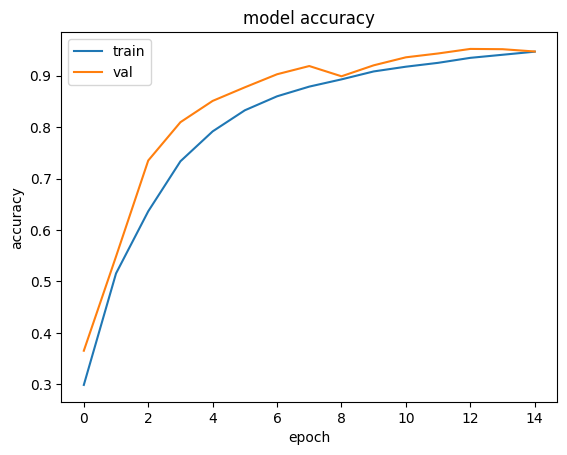

In [177]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

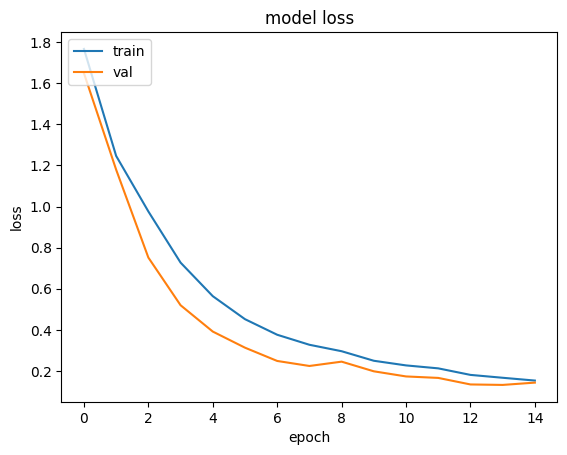

In [178]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [181]:
res = model.evaluate(X_test, Y_test)

294/294 [==============================] - 50s 170ms/step - loss: 0.1429 - acc: 0.9467 - recall_1: 0.9397 - precision_1: 0.9552 - auc_1: 0.9971 - true_positives_1: 8821.0000 - true_negatives_1: 55908.0000 - false_negatives_1: 566.0000 - false_positives_1: 414.0000


In [182]:
res

[0.1428976058959961,
 0.9467348456382751,
 0.9397038221359253,
 0.9551705718040466,
 0.9971082210540771,
 8821.0,
 55908.0,
 566.0,
 414.0]

In [ ]:
import cv2
srcdir = 'data\HAM10000_images_part_1'
count=0

In [ ]:
for temp in os.listdir(srcdir):
    img = cv2.imread(os.path.join(srcdir, temp))
    cv2.imwrite(temp, img)
    cv2_imshow(img)
    img = cv2.resize(img, (28, 28))
    result = model.predict(img.reshape(1, 28, 28, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    count+=1
    if count>10:
        break